In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
data = pd.read_csv('../data/train.csv')
data_to_predict = pd.read_csv('../data/test.csv')
data_ccrisk = pd.read_csv('../data/credit_risk_dataset.csv')

In [118]:
X_old = data.drop(['loan_status'], axis=1)
y_old = data['loan_status']

In [119]:
# Merge the dataframes
data_no_id = data.drop(['id'], axis=1)
merged_data = pd.concat([data_no_id, data_ccrisk], ignore_index=True)

X = merged_data.drop(['loan_status'], axis=1)
y = merged_data['loan_status']

# Preprocessing

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.2, random_state=2024)

In [122]:
categorical_columns = X.select_dtypes(include=['object']).columns

categorical_ordinal = ['loan_grade']
categorical_onehot = categorical_columns.drop(categorical_ordinal)

numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

In [123]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
	transformers=[
		('ordinal', OrdinalEncoder(), categorical_ordinal),
		('onehot', OneHotEncoder(), categorical_onehot),
		('scaler', StandardScaler(), numerical_columns)
	])

preprocessor.fit(X_train)

X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# XGBoost 1

In [124]:
import xgboost as xgb

In [125]:
dtrain = xgb.DMatrix(X_train_prep, label=y_train)
dtest = xgb.DMatrix(X_test_prep, label=y_test)

In [126]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist = [(dtest, 'evals'), (dtrain, 'train')]
num_round = 200
bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=10)

[0]	evals-auc:0.84207	train-auc:0.83769
[1]	evals-auc:0.87800	train-auc:0.87622
[2]	evals-auc:0.90210	train-auc:0.89971
[3]	evals-auc:0.91117	train-auc:0.90909
[4]	evals-auc:0.91436	train-auc:0.91238
[5]	evals-auc:0.91594	train-auc:0.91312
[6]	evals-auc:0.91760	train-auc:0.91557
[7]	evals-auc:0.92080	train-auc:0.91853
[8]	evals-auc:0.92287	train-auc:0.92072
[9]	evals-auc:0.92326	train-auc:0.92082
[10]	evals-auc:0.92403	train-auc:0.92164
[11]	evals-auc:0.92511	train-auc:0.92269
[12]	evals-auc:0.92572	train-auc:0.92358
[13]	evals-auc:0.92627	train-auc:0.92397
[14]	evals-auc:0.92636	train-auc:0.92399
[15]	evals-auc:0.92891	train-auc:0.92697
[16]	evals-auc:0.93037	train-auc:0.92825
[17]	evals-auc:0.93234	train-auc:0.93095
[18]	evals-auc:0.93264	train-auc:0.93111
[19]	evals-auc:0.93456	train-auc:0.93257
[20]	evals-auc:0.93511	train-auc:0.93332
[21]	evals-auc:0.93569	train-auc:0.93391
[22]	evals-auc:0.93721	train-auc:0.93575
[23]	evals-auc:0.93931	train-auc:0.93725
[24]	evals-auc:0.93970	tra

## Cross Validation

<Axes: title={'center': 'AUC'}>

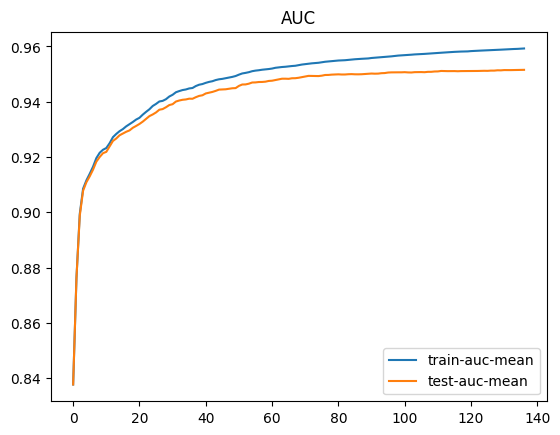

In [127]:
cv_results = xgb.cv(param, dtrain, num_round, nfold=5, metrics={'auc'}, early_stopping_rounds=10)
cv_results = pd.DataFrame(cv_results)
cv_results.plot(y=['train-auc-mean', 'test-auc-mean'], title='AUC')

## Hyperparameter Tuning

## 1st Try

GridSearchCV:
```python
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
	}

Best_Parameters = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best_AUC_Score = 0.9528388314968684
```

## 2nd Try

GridSearchCV:

```python
param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.1, 0.2, 0.5],
    'n_estimators': [200, 300, 500],
	'subsample': [0.8],
    'colsample_bytree': [0.8],             
    'gamma': [0, 0.1, 0.3],                     
}

Best_Parameters = {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best_AUC_Score = 0.9543454696625759
```

## 3rd Try

RandomizedSearchCV:

```python
param_dist = {
	'max_depth': np.arange(3, 12),
	'learning_rate': np.linspace(0.01, 0.3, 20),
	'n_estimators': np.arange(300, 600, 25),
	'subsample': np.linspace(0.6, 1.0, 10),
	'colsample_bytree': np.linspace(0.5, 1.0, 10),
	'gamma': np.linspace(0, 0.3, 20),
	'min_child_weight': np.arange(1, 9),
}

Best_params = {
	'subsample': 0.9111111111111111,
	'n_estimators': 525,
	'min_child_weight': 5,
	'max_depth': 5,
	'learning_rate': 0.07105263157894737,
	'gamma': 0.3,
	'colsample_bytree': 0.5
	}

Best_AUC_score =  0.9532664601824515
```

In [128]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [132]:
# Using RandomizedSearchCV
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')

param_dist = {
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'n_estimators': np.arange(100, 1000, 100),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'gamma': np.linspace(0, 0.5, 6),
    'min_child_weight': np.arange(1, 6),
    'alpha': np.logspace(-3, 1, 5),  # L1 regularization
    'lambda': np.logspace(-3, 1, 5)  # L2 regularization
}

rs = RandomizedSearchCV(xgb_model, param_dist, n_iter=100, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=2024)

In [133]:
rs.fit(X_train_prep, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                        'lambda': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'min_child_weight': array([1, 2, 3, 4, 5]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=2024, scoring='roc_auc', verbose=1)

In [136]:
rs.best_params_, rs.best_score_

({'subsample': 1.0,
  'n_estimators': 800,
  'min_child_weight': 3,
  'max_depth': 6,
  'learning_rate': 0.10666666666666666,
  'lambda': 0.01,
  'gamma': 0.4,
  'colsample_bytree': 0.5,
  'alpha': 0.01},
 0.954668340990759)

In [137]:
xgb_best = rs.best_estimator_
xgb_best.fit(X_train_prep, y_train)

y_pred = xgb_best.predict_proba(X_test_prep)
roc_auc_score(y_test, y_pred[:, 1])

0.9600627499030651

In [143]:
import catboost as CatBoosterClassifier

In [144]:
cat_features = np.where(X_train.dtypes == object)[0]
cat_features

array([2, 4, 5, 9], dtype=int64)

In [145]:
cat_params = [
        {
            'task_type'           : "CPU",
            'loss_function'       : 'Logloss',
            'eval_metric'         : "AUC",
            'bagging_temperature' : 0.25,
            'colsample_bylevel'   : 0.40,
            'iterations'          : 5_000,
            'learning_rate'       : 0.045,
            'max_depth'           : 7,
            'l2_leaf_reg'         : 0.80,
            'min_data_in_leaf'    : 30,
            'random_strength'     : 0.25,
            'random_state': 42,
        },
        {
            'iterations': 1500,
            'depth': 6,
            'eta': 0.3, 
            'reg_lambda': 41.0, 
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'random_state': 42,
            'min_data_in_leaf': 51,
            'early_stopping_rounds': 150,
            'verbose':200,
        },
        {
            'iterations': 3000,
            'depth': 7,
            'eta': 0.3, 
            'reg_lambda': 40.0, 
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'random_state': 42,
            'min_data_in_leaf': 51,
            'early_stopping_rounds': 300,
            'verbose':200,
        },
        {
            'task_type'           : "CPU",
            'loss_function'       : 'Logloss',
            'eval_metric'         : "AUC",
            'bagging_temperature' : 0.25,
            'colsample_bylevel'   : 0.40,
            'iterations'          : 7_000,
            'learning_rate'       : 0.035,
            'max_depth'           : 8,
            'l2_leaf_reg'         : 0.80,
            'min_data_in_leaf'    : 30,
            'random_strength'     : 0.25,
            'early_stopping_rounds': 200,
            'random_state': 42,
        },
    ]    

In [148]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.2, random_state=2024)

In [151]:
cat_clf_0 = CatBoosterClassifier.CatBoostClassifier(**cat_params[0])
cat_clf_0.fit(X_train_cat, y_train_cat, cat_features=cat_features, eval_set=(X_test_cat, y_test_cat), early_stopping_rounds=200, verbose=50)

0:	test: 0.8624934	best: 0.8624934 (0)	total: 101ms	remaining: 8m 22s
50:	test: 0.9265291	best: 0.9265291 (50)	total: 7.27s	remaining: 11m 45s
100:	test: 0.9347965	best: 0.9347965 (100)	total: 14.7s	remaining: 11m 50s
150:	test: 0.9399071	best: 0.9399071 (150)	total: 22.8s	remaining: 12m 13s
200:	test: 0.9429913	best: 0.9429913 (200)	total: 30.1s	remaining: 11m 58s
250:	test: 0.9448070	best: 0.9448295 (249)	total: 36.7s	remaining: 11m 33s
300:	test: 0.9464600	best: 0.9464600 (300)	total: 42.6s	remaining: 11m 5s
350:	test: 0.9479376	best: 0.9479376 (350)	total: 49s	remaining: 10m 48s
400:	test: 0.9489621	best: 0.9489830 (399)	total: 55.4s	remaining: 10m 35s
450:	test: 0.9503349	best: 0.9503349 (450)	total: 1m 1s	remaining: 10m 20s
500:	test: 0.9506825	best: 0.9506928 (499)	total: 1m 7s	remaining: 10m 7s
550:	test: 0.9520689	best: 0.9520775 (549)	total: 1m 14s	remaining: 10m
600:	test: 0.9527808	best: 0.9527808 (600)	total: 1m 20s	remaining: 9m 47s
650:	test: 0.9533661	best: 0.9533661 (6

In [164]:
cat_clf_1 = CatBoosterClassifier.CatBoostClassifier(**cat_params[1])
cat_clf_1.fit(X_train_prep, y_train, eval_set=(X_test_prep, y_test_cat), early_stopping_rounds=200, verbose=50)

0:	test: 0.8855804	best: 0.8855804 (0)	total: 28.4ms	remaining: 42.5s
50:	test: 0.9466704	best: 0.9466704 (50)	total: 1.7s	remaining: 48.4s
100:	test: 0.9532432	best: 0.9532432 (100)	total: 3.19s	remaining: 44.1s
150:	test: 0.9547997	best: 0.9548737 (136)	total: 4.51s	remaining: 40.3s
200:	test: 0.9570397	best: 0.9570397 (200)	total: 5.84s	remaining: 37.7s
250:	test: 0.9575087	best: 0.9575325 (247)	total: 7.09s	remaining: 35.3s
300:	test: 0.9580442	best: 0.9580442 (300)	total: 8.5s	remaining: 33.9s
350:	test: 0.9586021	best: 0.9586160 (344)	total: 10.1s	remaining: 33.1s
400:	test: 0.9585136	best: 0.9587749 (363)	total: 11.4s	remaining: 31.3s
450:	test: 0.9588652	best: 0.9588662 (443)	total: 12.9s	remaining: 30.1s
500:	test: 0.9588589	best: 0.9589277 (455)	total: 14.3s	remaining: 28.6s
550:	test: 0.9588397	best: 0.9589546 (517)	total: 15.9s	remaining: 27.5s
600:	test: 0.9588573	best: 0.9589546 (517)	total: 17.3s	remaining: 25.9s
650:	test: 0.9591834	best: 0.9591958 (646)	total: 19.2s	re

In [165]:
cat_clf_2 = CatBoosterClassifier.CatBoostClassifier(**cat_params[2])
cat_clf_2.fit(X_train_prep, y_train, eval_set=(X_test_prep, y_test_cat), early_stopping_rounds=200, verbose=50)

0:	test: 0.8884270	best: 0.8884270 (0)	total: 39.3ms	remaining: 1m 57s
50:	test: 0.9490826	best: 0.9490826 (50)	total: 1.76s	remaining: 1m 41s
100:	test: 0.9536958	best: 0.9536958 (100)	total: 3.55s	remaining: 1m 41s
150:	test: 0.9552012	best: 0.9552020 (149)	total: 5.21s	remaining: 1m 38s
200:	test: 0.9567336	best: 0.9567336 (200)	total: 7.19s	remaining: 1m 40s
250:	test: 0.9572742	best: 0.9573473 (225)	total: 9.39s	remaining: 1m 42s
300:	test: 0.9575185	best: 0.9575185 (300)	total: 11.2s	remaining: 1m 40s
350:	test: 0.9574038	best: 0.9575343 (323)	total: 12.7s	remaining: 1m 36s
400:	test: 0.9577072	best: 0.9577072 (400)	total: 14.4s	remaining: 1m 33s
450:	test: 0.9580413	best: 0.9580517 (449)	total: 15.9s	remaining: 1m 30s
500:	test: 0.9581806	best: 0.9582802 (482)	total: 17.4s	remaining: 1m 26s
550:	test: 0.9580079	best: 0.9582802 (482)	total: 19s	remaining: 1m 24s
600:	test: 0.9579940	best: 0.9582802 (482)	total: 20.6s	remaining: 1m 22s
650:	test: 0.9578055	best: 0.9582802 (482)	to

In [167]:
cat_clf_3 = CatBoosterClassifier.CatBoostClassifier(**cat_params[3])
cat_clf_3.fit(X_train_prep, y_train, eval_set=(X_test_prep, y_test_cat), early_stopping_rounds=200, verbose=50)

0:	test: 0.8958575	best: 0.8958575 (0)	total: 121ms	remaining: 14m 6s
50:	test: 0.9279955	best: 0.9279955 (50)	total: 2.22s	remaining: 5m 2s
100:	test: 0.9354182	best: 0.9354182 (100)	total: 4.26s	remaining: 4m 50s
150:	test: 0.9396179	best: 0.9396179 (150)	total: 6.32s	remaining: 4m 46s
200:	test: 0.9428561	best: 0.9428561 (200)	total: 8.34s	remaining: 4m 42s
250:	test: 0.9447389	best: 0.9447389 (250)	total: 10.3s	remaining: 4m 36s
300:	test: 0.9470127	best: 0.9470127 (300)	total: 12.1s	remaining: 4m 29s
350:	test: 0.9481959	best: 0.9481959 (350)	total: 13.9s	remaining: 4m 23s
400:	test: 0.9492682	best: 0.9492682 (400)	total: 15.7s	remaining: 4m 18s
450:	test: 0.9501160	best: 0.9501160 (450)	total: 17.5s	remaining: 4m 14s
500:	test: 0.9509767	best: 0.9509767 (500)	total: 19.4s	remaining: 4m 11s
550:	test: 0.9518964	best: 0.9519049 (549)	total: 21.1s	remaining: 4m 7s
600:	test: 0.9525691	best: 0.9525816 (596)	total: 22.9s	remaining: 4m 4s
650:	test: 0.9529495	best: 0.9529495 (650)	tota

In [155]:
y_preds_cat_0 = cat_clf_0.predict_proba(X_test_cat)
auc_cat_0 = roc_auc_score(y_test_cat, y_preds_cat_0[:, 1])

y_preds_cat_1 = cat_clf_1.predict_proba(X_test_cat)
auc_cat_1 = roc_auc_score(y_test_cat, y_preds_cat_1[:, 1])

y_preds_cat_2 = cat_clf_2.predict_proba(X_test_cat)
auc_cat_2 = roc_auc_score(y_test_cat, y_preds_cat_2[:, 1])

y_preds_cat_3 = cat_clf_3.predict_proba(X_test_cat)
auc_cat_3 = roc_auc_score(y_test_cat, y_preds_cat_3[:, 1])

auc_cat_0, auc_cat_1, auc_cat_2, auc_cat_3

(0.9572242868857734,
 0.9592276090524516,
 0.9589631614774814,
 0.9567769391641247)

# Predictions and submission

In [168]:
cat_clf_1.fit(preprocessor.transform(X), y, verbose=50, early_stopping_rounds=200)

0:	total: 32.9ms	remaining: 49.3s
50:	total: 1.58s	remaining: 45s
100:	total: 3.01s	remaining: 41.7s
150:	total: 4.43s	remaining: 39.6s
200:	total: 5.89s	remaining: 38.1s
250:	total: 7.28s	remaining: 36.2s
300:	total: 8.67s	remaining: 34.5s
350:	total: 10.1s	remaining: 33.2s
400:	total: 11.7s	remaining: 32s
450:	total: 13.1s	remaining: 30.5s
500:	total: 14.5s	remaining: 28.9s
550:	total: 15.9s	remaining: 27.3s
600:	total: 17.3s	remaining: 25.8s
650:	total: 18.5s	remaining: 24.2s
700:	total: 19.9s	remaining: 22.7s
750:	total: 21.2s	remaining: 21.2s
800:	total: 23s	remaining: 20s
850:	total: 24.7s	remaining: 18.8s
900:	total: 26.1s	remaining: 17.4s
950:	total: 27.5s	remaining: 15.9s
1000:	total: 29s	remaining: 14.4s
1050:	total: 30.4s	remaining: 13s
1100:	total: 31.8s	remaining: 11.5s
1150:	total: 33.2s	remaining: 10.1s
1200:	total: 34.6s	remaining: 8.61s
1250:	total: 36.1s	remaining: 7.18s
1300:	total: 37.5s	remaining: 5.73s
1350:	total: 38.9s	remaining: 4.29s
1400:	total: 40.2s	remaini

In [172]:
y_preds_cat = cat_clf_1.predict_proba(preprocessor.transform(data_to_predict))[:,1]
y_preds_cat

array([0.99977203, 0.05595793, 0.51426483, ..., 0.00193344, 0.21880379,
       0.95807827])

In [173]:
# to DF
submission = pd.DataFrame({'id': data_to_predict['id'], 'loan_status': y_preds_cat})
submission.to_csv('../submissions/catboost_v1.csv', index=False)

# Experimenting with stacking

In [176]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [177]:
xgb_v2 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')
xgb_v2.load_model('../models/xgboost_v2.json')

xgb_v3 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')
xgb_v3.load_model('../models/xgboost_v3.json')

cat_v1 = cat_clf_1

log_reg = LogisticRegression()

estimators = [
	('xgb_v2', xgb_v2),
	('xgb_v3', xgb_v3),
	('cat_v1', cat_v1)
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=log_reg, cv=5)

In [178]:
stacking_clf.fit(X_train_prep, y_train)

0:	total: 29ms	remaining: 43.5s
200:	total: 5.32s	remaining: 34.4s
400:	total: 10.5s	remaining: 28.9s
600:	total: 15.2s	remaining: 22.7s
800:	total: 20.1s	remaining: 17.5s
1000:	total: 25.2s	remaining: 12.6s
1200:	total: 30.2s	remaining: 7.51s
1400:	total: 35.4s	remaining: 2.5s
1499:	total: 37.9s	remaining: 0us
0:	total: 22.7ms	remaining: 34s
200:	total: 4.41s	remaining: 28.5s
400:	total: 8.64s	remaining: 23.7s
600:	total: 12.9s	remaining: 19.3s
800:	total: 17.1s	remaining: 14.9s
1000:	total: 21.7s	remaining: 10.8s
1200:	total: 26.2s	remaining: 6.52s
1400:	total: 30.7s	remaining: 2.17s
1499:	total: 32.9s	remaining: 0us
0:	total: 21.9ms	remaining: 32.9s
200:	total: 4.34s	remaining: 28.1s
400:	total: 8.61s	remaining: 23.6s
600:	total: 12.8s	remaining: 19.2s
800:	total: 16.7s	remaining: 14.6s
1000:	total: 21s	remaining: 10.5s
1200:	total: 25.8s	remaining: 6.41s
1400:	total: 31.7s	remaining: 2.24s
1499:	total: 34.2s	remaining: 0us
0:	total: 25ms	remaining: 37.4s
200:	total: 5.2s	remaining:

StackingClassifier(cv=5,
                   estimators=[('xgb_v2',
                                XGBClassifier(base_score='1.9302522E-1',
                                              booster='gbtree', callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_con...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('cat_v1',
                                <catboost.core.CatBoostClassifier object at 0x0000024191EC5400>)],
                   final_estimator=LogisticRegression())

In [179]:
y_preds_stacking = stacking_clf.predict_proba(X_test_prep)
roc_auc_score(y_test, y_preds_stacking[:, 1])

0.9607703941986889

In [180]:
stacking_clf.fit(preprocessor.transform(X), y)
y_preds_stacking_sub = stacking_clf.predict_proba(preprocessor.transform(data_to_predict))[:, 1]

0:	total: 27ms	remaining: 40.4s
200:	total: 7.8s	remaining: 50.4s
400:	total: 14.1s	remaining: 38.6s
600:	total: 19.8s	remaining: 29.7s
800:	total: 25.4s	remaining: 22.2s
1000:	total: 31.1s	remaining: 15.5s
1200:	total: 36.8s	remaining: 9.17s
1400:	total: 42.8s	remaining: 3.03s
1499:	total: 45.6s	remaining: 0us
0:	total: 27.1ms	remaining: 40.6s
200:	total: 5.14s	remaining: 33.2s
400:	total: 10.2s	remaining: 28s
600:	total: 15.4s	remaining: 23s
800:	total: 20.4s	remaining: 17.8s
1000:	total: 25.4s	remaining: 12.7s
1200:	total: 30.5s	remaining: 7.59s
1400:	total: 35.4s	remaining: 2.5s
1499:	total: 37.9s	remaining: 0us
0:	total: 23.3ms	remaining: 34.9s
200:	total: 4.96s	remaining: 32.1s
400:	total: 9.99s	remaining: 27.4s
600:	total: 15.2s	remaining: 22.8s
800:	total: 20.2s	remaining: 17.7s
1000:	total: 25.6s	remaining: 12.7s
1200:	total: 30.5s	remaining: 7.59s
1400:	total: 35.2s	remaining: 2.49s
1499:	total: 37.5s	remaining: 0us
0:	total: 23.8ms	remaining: 35.6s
200:	total: 5.17s	remainin

In [181]:
submission = pd.DataFrame({'id': data_to_predict['id'], 'loan_status': y_preds_stacking_sub})
submission.to_csv('../submissions/stacking_v1.csv', index=False)